# This notebook include the code for COMP4447 Final Project.
## Data Cleaning, Extraction, and Visualization.

In [274]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import geopandas 
import plotly.express as px
import folium

The Crime Dataset includes crime data from Los Angeles County, CA between 2010-2015 (approximately 1.1 million incidents)

In [275]:
crimeData = pd.read_csv('CrimeData.csv')

In [276]:
crimeData.sample(n=10)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
105429,100212818,2010-06-09T00:00:00,2010-06-09T00:00:00,1750,2,Rampart,236,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0104 0325 0344,...,NaN,IC,Invest Cont,442.0,NaN,NaN,NaN,1800 W 3RD ST,NaN,"{'latitude': '34.0613', 'needs_recoding': Fals..."
1699593,180322004,2018-09-27T00:00:00,2018-09-25T00:00:00,1215,3,Southwest,358,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344 2032 1210,...,NaN,IC,Invest Cont,341.0,NaN,NaN,NaN,3500 TROUSDALE PY,NaN,"{'latitude': '34.0215', 'needs_recoding': Fals..."
995758,152108303,2015-04-06T00:00:00,2014-06-15T00:00:00,1200,21,Topanga,2126,310,BURGLARY,1402 0321 1601 0344,...,NaN,IC,Invest Cont,310.0,998.0,NaN,NaN,7900 DEERING AV,NaN,"{'latitude': '34.2141', 'needs_recoding': Fals..."
1269094,160615185,2016-06-29T00:00:00,2016-06-29T00:00:00,1350,6,Hollywood,678,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",NaN,...,SEMI-AUTOMATIC PISTOL,JA,Juv Arrest,230.0,NaN,NaN,NaN,800 N HARVARD BL,NaN,"{'latitude': '34.085', 'needs_recoding': False..."
215313,110121117,2011-12-06T00:00:00,2011-12-06T00:00:00,1100,1,Central,164,354,THEFT OF IDENTITY,0377,...,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,600 S SPRING ST,NaN,"{'latitude': '34.046', 'needs_recoding': False..."
42954,101509790,2010-04-05T00:00:00,2010-04-03T00:00:00,1300,15,N Hollywood,1562,330,BURGLARY FROM VEHICLE,0344 1307 1609,...,NaN,IC,Invest Cont,330.0,NaN,NaN,NaN,12700 KLING ST,NaN,"{'latitude': '34.1558', 'needs_recoding': Fals..."
535905,121424885,2012-10-03T00:00:00,2012-10-01T00:00:00,2200,14,Pacific,1409,520,VEHICLE - ATTEMPT STOLEN,1501,...,NaN,IC,Invest Cont,520.0,NaN,NaN,NaN,3700 BAGLEY AV,NaN,"{'latitude': '34.0277', 'needs_recoding': Fals..."
1840201,181709426,2018-04-21T00:00:00,2018-04-21T00:00:00,1640,17,Devonshire,1757,626,INTIMATE PARTNER - SIMPLE ASSAULT,2000 1241 0416,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,626.0,NaN,NaN,NaN,10200 RUFFNER AV,NaN,"{'latitude': '34.2561', 'needs_recoding': Fals..."
729672,131421907,2013-08-31T00:00:00,2013-08-25T00:00:00,1330,14,Pacific,1494,440,THEFT PLAIN - PETTY ($950 & UNDER),0344 1501,...,NaN,IC,Invest Cont,440.0,NaN,NaN,NaN,400 WORLD WY,NaN,"{'latitude': '33.9433', 'needs_recoding': Fals..."
221113,110216563,2011-09-01T00:00:00,2011-08-25T00:00:00,1600,2,Rampart,275,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,0421 0432 0443 1813 2000,...,VERBAL THREAT,AO,Adult Other,930.0,NaN,NaN,NaN,1600 W 11TH ST,NaN,"{'latitude': '34.0477', 'needs_recoding': Fals..."


For the purpose of this project, we won't need all the attributes from the original dataset.
Only a few columns will be selected.

In [277]:
print(crimeData.columns)
crimeData = crimeData[['Date Reported', 'Date Occurred', 'Crime Code Description', 'Victim Sex', 'Weapon Description', 'Location ']]
crimeData = crimeData.rename(columns={'Date Reported': 'Report_Date', 'Date Occurred': 'Incident_Date', 
                                    'Crime Code Description': 'Crime', 'Weapon Description': 'Weapon',
                                    'Location ': 'Location'})

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')


In [278]:
crimeData.columns

Index(['Report_Date', 'Incident_Date', 'Crime', 'Victim Sex', 'Weapon',
       'Location'],
      dtype='object')

Current location columns include latitude and logitude data along with other things in a string that's not usable in current state.
Latitude and Longitude information will be extracted and added to separate columns.

In [279]:
## Initializing the new columns with NaNs
## Latitude and Longitude data will be loaded into the columns
crimeData['Lat'] = np.nan
crimeData['Long'] = np.nan

for i in range(len(crimeData['Location'])):
    crimeData['Lat'].at[i] = re.findall(r"\'latitude\'\: \'(\S*)\'", str(crimeData['Location'].at[i]))[0]
    crimeData['Long'].at[i] = re.findall(r"\'longitude\'\: \'(\S*)\'", str(crimeData['Location'].at[i]))[0]

In [280]:
crimeData.Lat = crimeData['Lat'].astype(float)
crimeData.Long = crimeData['Long'].astype(float)

In [281]:
## Dropping the rows with no location data. approx. 900 rows
crimeData = crimeData[crimeData['Lat']>30]

crimeData.drop(columns =['Location'], inplace= True)

crimeData.head(20)

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long
0,2010-01-25T00:00:00,2010-01-22T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.0454,-118.3157
1,2010-11-11T00:00:00,2010-11-10T00:00:00,VEHICLE - STOLEN,NaN,NaN,33.9572,-118.2717
2,2010-01-28T00:00:00,2010-01-27T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.1211,-118.2048
3,2010-11-11T00:00:00,2010-11-07T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.2410,-118.3987
4,2010-04-07T00:00:00,2010-04-07T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.3147,-118.4589
5,2010-12-31T00:00:00,2010-12-30T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.2354,-118.4517
6,2010-10-26T00:00:00,2010-10-26T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.0294,-118.2671
7,2010-04-20T00:00:00,2010-04-20T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.2139,-118.4793
8,2010-12-21T00:00:00,2010-12-21T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.2550,-118.4103
9,2010-02-04T00:00:00,2010-02-03T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.1351,-118.2153


In [282]:
gdf = geopandas.GeoDataFrame(
    crimeData, geometry=geopandas.points_from_xy(crimeData.Long, crimeData.Lat))

#A GeoJSON map downloaded from "https://github.com/datadesk/mapping-la-data"
LACounty = geopandas.read_file('./LARegion.geojson')

gdf.head()

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long,geometry
0,2010-01-25T00:00:00,2010-01-22T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.0454,-118.3157,POINT (-118.31570 34.04540)
1,2010-11-11T00:00:00,2010-11-10T00:00:00,VEHICLE - STOLEN,NaN,NaN,33.9572,-118.2717,POINT (-118.27170 33.95720)
2,2010-01-28T00:00:00,2010-01-27T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.1211,-118.2048,POINT (-118.20480 34.12110)
3,2010-11-11T00:00:00,2010-11-07T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.2410,-118.3987,POINT (-118.39870 34.24100)
4,2010-04-07T00:00:00,2010-04-07T00:00:00,VEHICLE - STOLEN,NaN,NaN,34.3147,-118.4589,POINT (-118.45890 34.31470)


<ipython-input-283-cbdff2cd09fe>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'], xy=row['coords'],


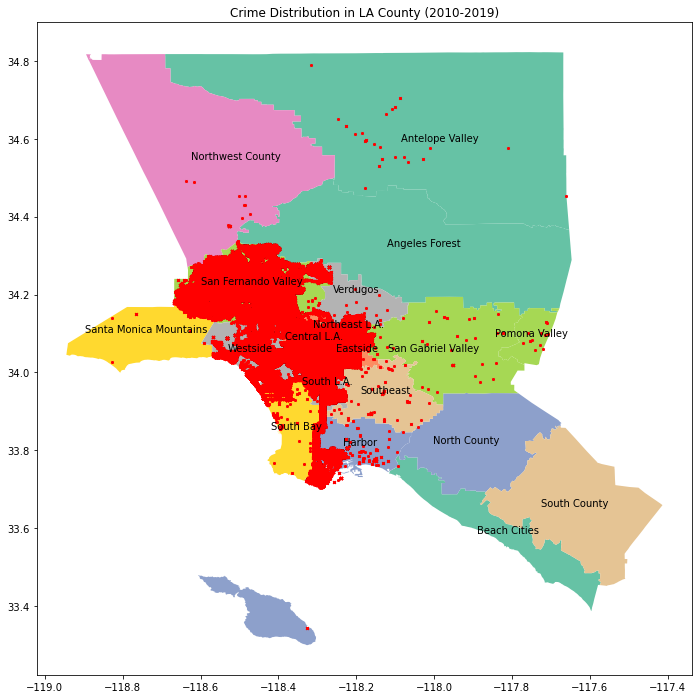

In [283]:

LACounty['coords'] = LACounty['geometry'].apply(lambda x: x.representative_point().coords[:])
LACounty['coords'] = [coords[0] for coords in LACounty['coords']]


gdf.plot(ax=LACounty.plot(cmap= 'Set2', figsize=(20,12)), marker='x', color='red', markersize=5) 


for idx, row in LACounty.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.title('Crime Distribution in LA County (2010-2019)')
plt.show()


In [284]:
crimeData.Weapon = crimeData['Weapon'].replace(['HAND GUN', 'SEMI-AUTOMATIC PISTOL', 'UNKNOWN FIREARM', 'REVOLVER',
                                                'OTHER FIREARM', 'SHOTGUN', 'SAWED OFF RIFLE/SHOTGUN', 'RIFLE',
                                                'UZI SEMIAUTOMATIC ASSAULT RIFLE', 'ASSAULT WEAPON/UZI/AK47/ETC',
                                                'STARTER PISTOL/REVOLVER', 'AUTOMATIC WEAPON/SUB-MACHINE GUN',
                                                'UNK TYPE SEMIAUTOMATIC ASSAULT RIFLE',  'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE',
                                                'HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE',  'MAC-10 SEMIAUTOMATIC ASSAULT WEAPON',
                                                'RELIC FIREARM', 'ANTIQUE FIREARM', 'MAC-11 SEMIAUTOMATIC ASSAULT WEAPON',
                                                'M-14 SEMIAUTOMATIC ASSAULT RIFLE', 'M1-1 SEMIAUTOMATIC ASSAULT RIFLE',
                                                'SEMI-AUTOMATIC RIFLE'], 'Firearm')

In [285]:
crimeData.Weapon= crimeData['Weapon'].replace(['FOLDING KNIFE', 'OTHER KNIFE', 'KITCHEN KNIFE', 'SWORD',
                                                'KNIFE WITH BLADE 6INCHES OR LESS', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
                                                'SWITCH BLADE', 'MACHETE',  'OTHER CUTTING INSTRUMENT', 'RAZOR',
                                                'STRAIGHT RAZOR', 'BOWIE KNIFE', 'RAZOR BLADE', 'CLEAVER', 'UNKNOWN TYPE CUTTING INSTRUMENT'], "Knife/Blade")
crimeData['Weapon'].unique()

array([nan, 'VERBAL THREAT', 'Knife/Blade',
       'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'Firearm',
       'CLUB/BAT', 'VEHICLE', 'BELT FLAILING INSTRUMENT/CHAIN',
       'UNKNOWN WEAPON/OTHER WEAPON', 'BOTTLE', 'SIMULATED GUN',
       'STUN GUN', 'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'BLUNT INSTRUMENT',
       'MACE/PEPPER SPRAY', 'SCREWDRIVER', 'FIXED OBJECT', 'AXE', 'STICK',
       'BOMB THREAT', 'EXPLOXIVE DEVICE', 'ROCK/THROWN OBJECT',
       'DEMAND NOTE', 'CAUSTIC CHEMICAL/POISON', 'DIRK/DAGGER', 'FIRE',
       'TIRE IRON', 'SCISSORS', 'BRASS KNUCKLES', 'BOARD',
       'SCALDING LIQUID', 'LIQUOR/DRUGS', 'BLACKJACK', 'TOY GUN',
       'ICE PICK', 'ROPE/LIGATURE', 'BOW AND ARROW', 'GLASS',
       'PHYSICAL PRESENCE', 'MARTIAL ARTS WEAPONS', 'SYRINGE', 'HAMMER',
       'CONCRETE BLOCK/BRICK', 'PIPE/METAL PIPE',
       'DOG/ANIMAL (SIC ANIMAL ON)'], dtype=object)

In [286]:
crimeData.Weapon = crimeData['Weapon'].replace({'VERBAL THREAT': 'Verbal', 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)': 'Physical/Body Force',
                                                'CLUB/BAT': 'Club/Bat', 'VEHICLE': 'Vehicle', 'BELT FLAILING INSTRUMENT/CHAIN': 'Chain',
                                                'UNKNOWN WEAPON/OTHER WEAPON': 'Unknown Weapon', 'BOTTLE': 'Bottle',  'STUN GUN': 'Stun Gun',
                                                'SIMULATED GUN': 'Simulated Gun', 'AIR PISTOL/REVOLVER/RIFLE/BB GUN': 'Simulated Gun',
                                                'BLUNT INSTRUMENT': 'Blunt Instrument','MACE/PEPPER SPRAY': 'Pepper Spray', 'SCREWDRIVER': 'Screwdriver',
                                                'FIXED OBJECT': 'Fixed Object', 'AXE': 'Axe', 'STICK': 'Blunt Instrument', 'BOMB THREAT': 'Bomb Threat',
                                                'EXPLOXIVE DEVICE': 'Explosive Device', 'ROCK/THROWN OBJECT': 'Rock/Thrown Object',
                                                'DEMAND NOTE': 'Demand Note', 'CAUSTIC CHEMICAL/POISON': 'Chemical/Poison', 'DIRK/DAGGER': 'Knife/Blade',
                                                'FIRE': 'Fire',  'TIRE IRON': "Blunt Instrument", 'SCISSORS': 'Scissors', 'BRASS KNUCKLES': 'Brass Knuckles',
                                                'BOARD': 'Blunt Instrument', 'SCALDING LIQUID': 'Scalding Liquid', 'LIQUOR/DRUGS': 'Liquor/Drugs',
                                                'BLACKJACK': 'Blunt Instrument', 'TOY GUN': 'Simulated Gun', 'ICE PICK': 'Ice Pick', 'ROPE/LIGATURE': 'Rope',
                                                'BOW AND ARROW': 'Bow and Arrow', 'GLASS': 'Glass', 'PHYSICAL PRESENCE': 'Physical Presence',
                                                'MARTIAL ARTS WEAPONS': 'Martial Arts Weapon', 'SYRINGE': 'Syringe', 'HAMMER': 'Blunt Instrument', 
                                                'CONCRETE BLOCK/BRICK': 'Block/Brick', 'PIPE/METAL PIPE': "Blunt Instrument", 
                                                'DOG/ANIMAL (SIC ANIMAL ON)': 'Dog/Animal'})
crimeData['Weapon'].unique()

array([nan, 'Verbal', 'Knife/Blade', 'Physical/Body Force', 'Firearm',
       'Club/Bat', 'Vehicle', 'Chain', 'Unknown Weapon', 'Bottle',
       'Simulated Gun', 'Stun Gun', 'Blunt Instrument', 'Pepper Spray',
       'Screwdriver', 'Fixed Object', 'Axe', 'Bomb Threat',
       'Explosive Device', 'Rock/Thrown Object', 'Demand Note',
       'Chemical/Poison', 'Fire', 'Scissors', 'Brass Knuckles',
       'Scalding Liquid', 'Liquor/Drugs', 'Ice Pick', 'Rope',
       'Bow and Arrow', 'Glass', 'Physical Presence',
       'Martial Arts Weapon', 'Syringe', 'Block/Brick', 'Dog/Animal'],
      dtype=object)

In [287]:
crimeData.dropna(subset=['Weapon'], inplace= True)

In [288]:
crimeData.sample(n=10)

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long,geometry
1918564,1042019-01-01T00:00:00,2019-01-04T00:00:00,"RAPE, FORCIBLE",F,Physical/Body Force,34.1074,-118.3333,POINT (-118.33330 34.10740)
1915565,2072019-01-01T00:00:00,2019-02-03T00:00:00,INTIMATE PARTNER - SIMPLE ASSAULT,F,Physical/Body Force,33.7778,-118.2766,POINT (-118.27660 33.77780)
1252189,2016-09-14T00:00:00,2016-09-14T00:00:00,INTIMATE PARTNER - AGGRAVATED ASSAULT,F,Physical/Body Force,34.0787,-118.2028,POINT (-118.20280 34.07870)
1967084,6222019-01-01T00:00:00,2019-06-22T00:00:00,CRIMINAL THREATS - NO WEAPON DISPLAYED,M,Verbal,34.1424,-118.3658,POINT (-118.36580 34.14240)
1820146,2018-03-05T00:00:00,2018-03-04T00:00:00,INTIMATE PARTNER - AGGRAVATED ASSAULT,M,Knife/Blade,34.2027,-118.3745,POINT (-118.37450 34.20270)
367686,2011-05-01T00:00:00,2011-05-01T00:00:00,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,Firearm,33.9601,-118.2869,POINT (-118.28690 33.96010)
1633377,2017-06-05T00:00:00,2017-06-05T00:00:00,BATTERY - SIMPLE ASSAULT,M,Physical/Body Force,34.2386,-118.4464,POINT (-118.44640 34.23860)
1860370,2018-03-19T00:00:00,2018-03-19T00:00:00,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,Simulated Gun,34.3198,-118.4622,POINT (-118.46220 34.31980)
319960,2011-04-07T00:00:00,2011-04-07T00:00:00,"THEFT, PERSON",M,Physical/Body Force,34.0039,-118.2635,POINT (-118.26350 34.00390)
1357824,2016-12-20T00:00:00,2016-12-15T00:00:00,BURGLARY,M,Unknown Weapon,34.0253,-118.4354,POINT (-118.43540 34.02530)


Text(0.5, 1.0, 'Crime Weapon Used (excluding physical/body force)')

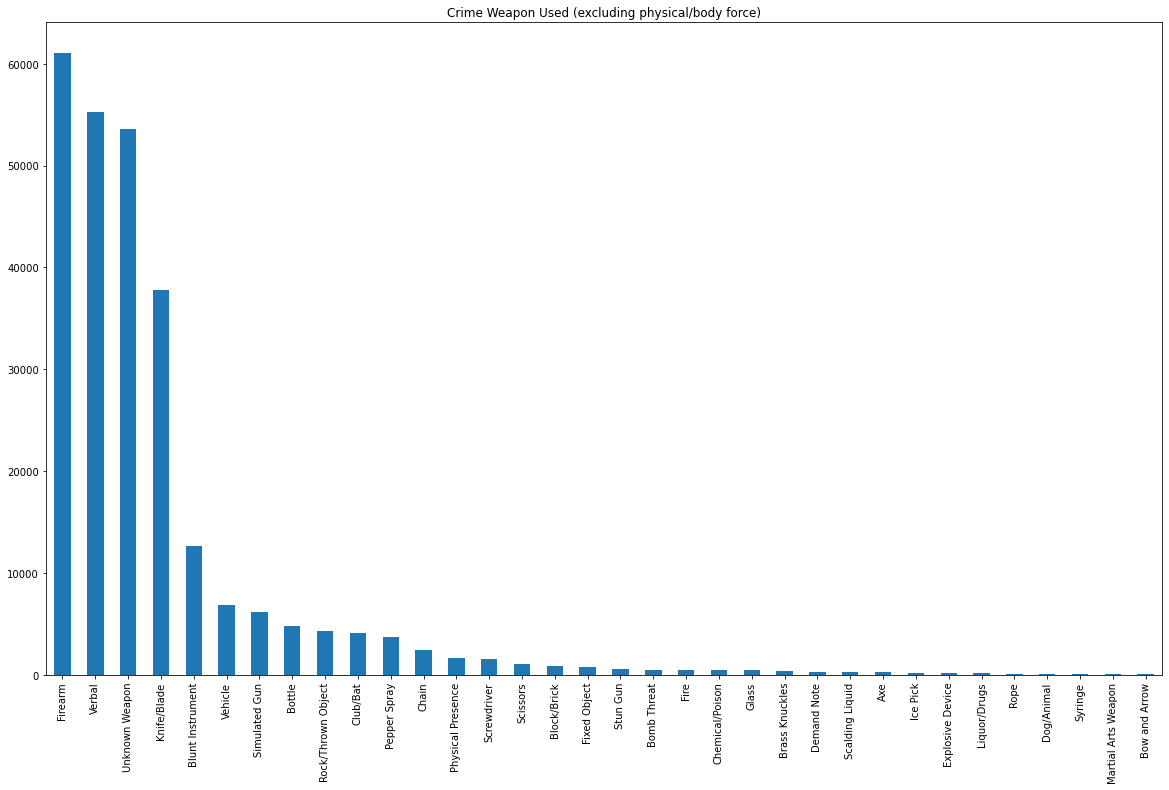

In [289]:
cWeap = pd.value_counts(crimeData.Weapon[crimeData['Weapon']!='Physical/Body Force']).plot.bar(figsize= (20,12))
plt.title('Crime Weapon Used (excluding physical/body force)')

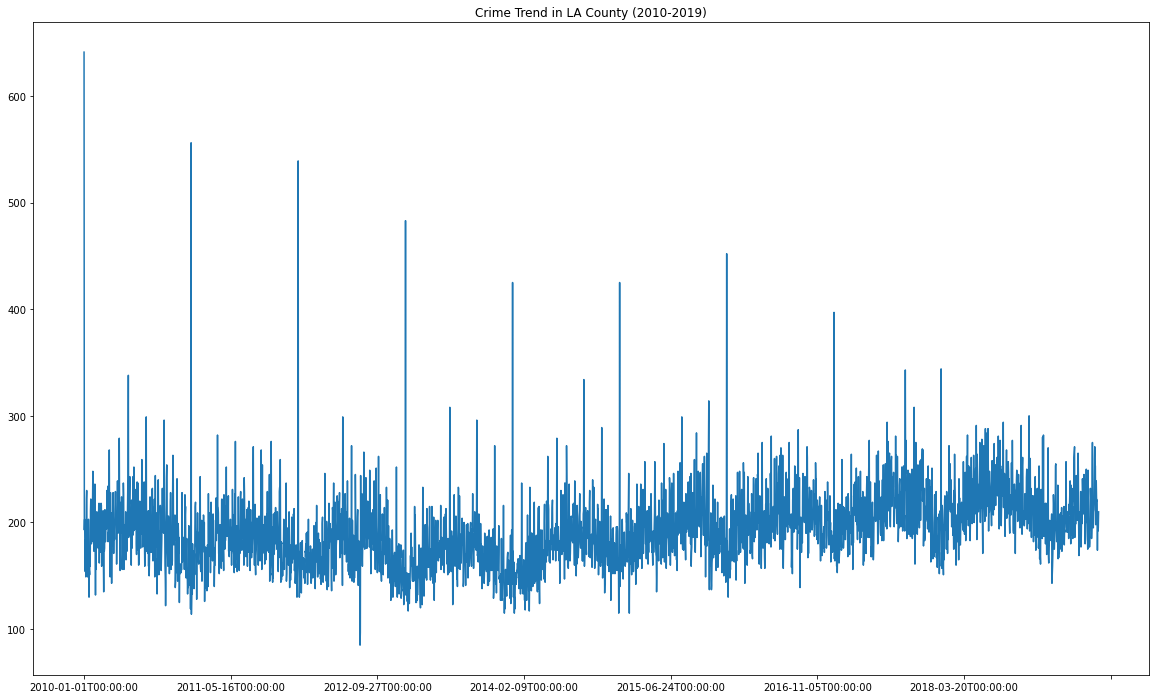

In [290]:
crimeData['Incident_Date'].value_counts().sort_index().plot.line(figsize=(20,12))
plt.title('Crime Trend in LA County (2010-2019)')
plt.show()

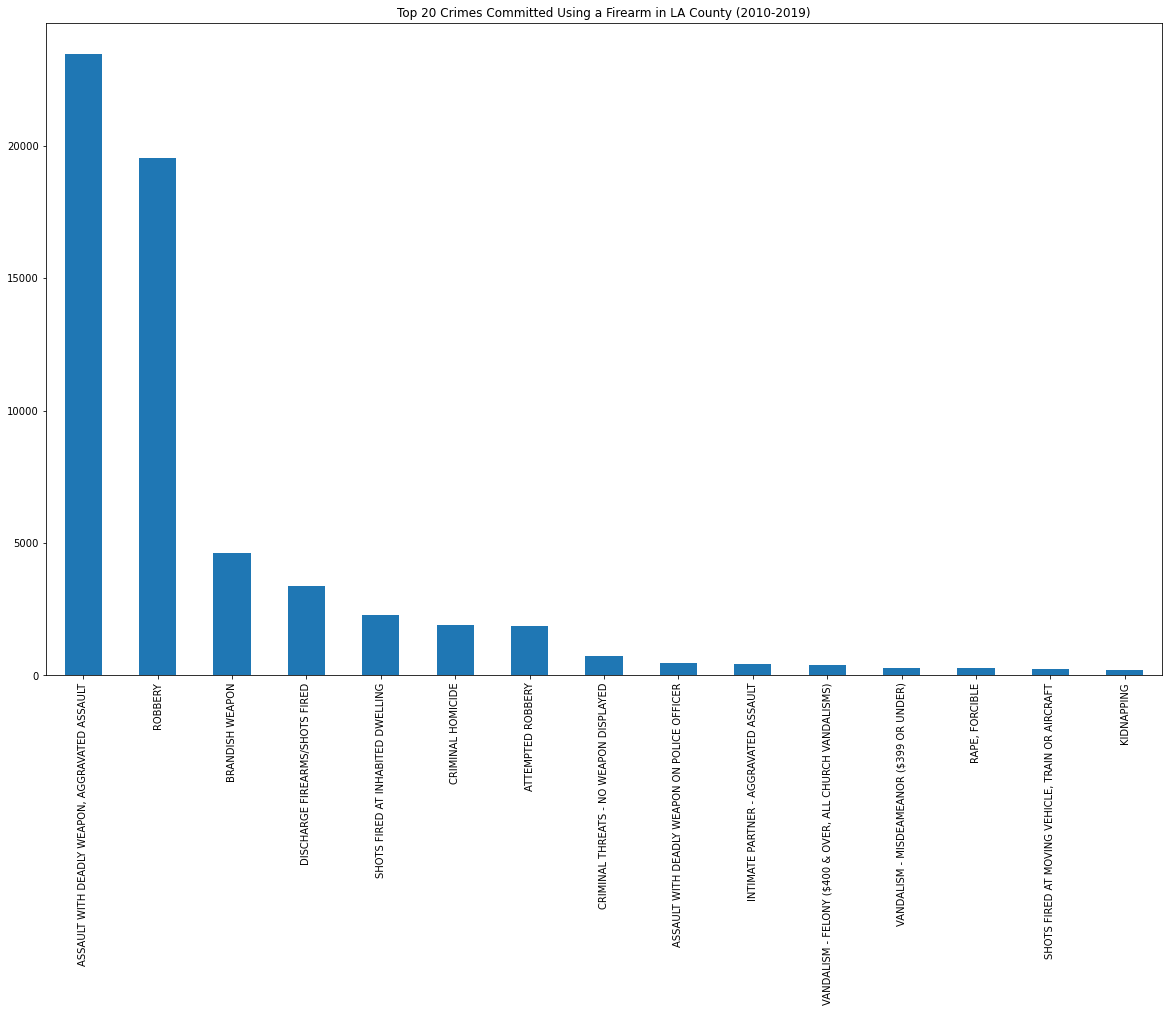

In [291]:
gunCrime= crimeData[crimeData['Weapon']== 'Firearm']
gunCrime['Crime'].value_counts().head(15).plot.bar(figsize=(20,12))
plt.title('Top 20 Crimes Committed Using a Firearm in LA County (2010-2019)')
plt.show()

In [292]:
vicSex= crimeData['Victim Sex']

vicSex.dropna(inplace= True)

<AxesSubplot:>

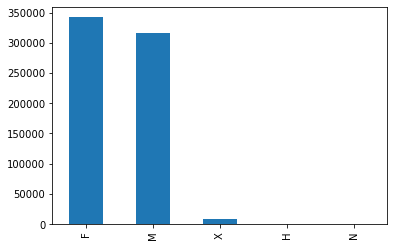

In [293]:
vicSex.value_counts().plot.bar()

<ipython-input-294-46566af362e3>:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'], xy=row['coords'],


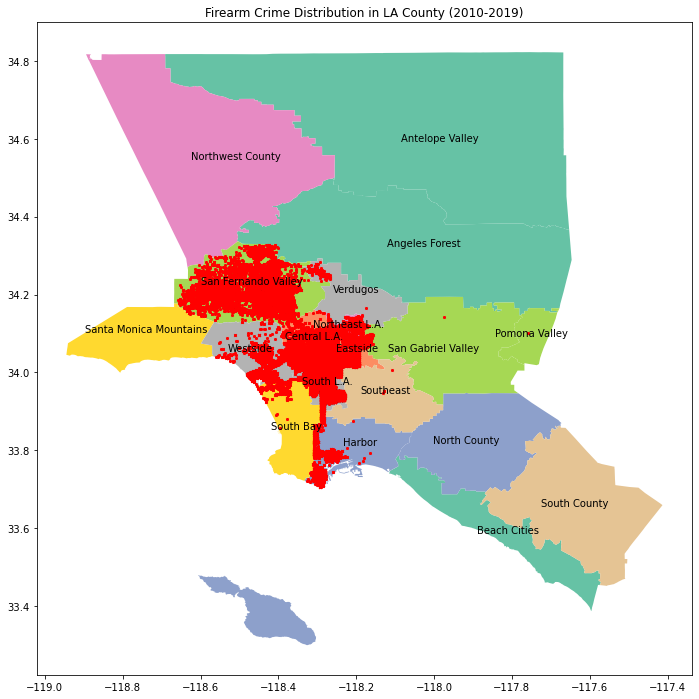

In [294]:
firearm= gdf[gdf['Weapon']=='Firearm']

firearm.plot(ax=LACounty.plot(cmap= 'Set2', figsize=(20,12)), marker='x', color='red', markersize=5) 


for idx, row in LACounty.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.title('Firearm Crime Distribution in LA County (2010-2019)')
plt.show()

<ipython-input-295-bc5d13bd1e87>:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'], xy=row['coords'],


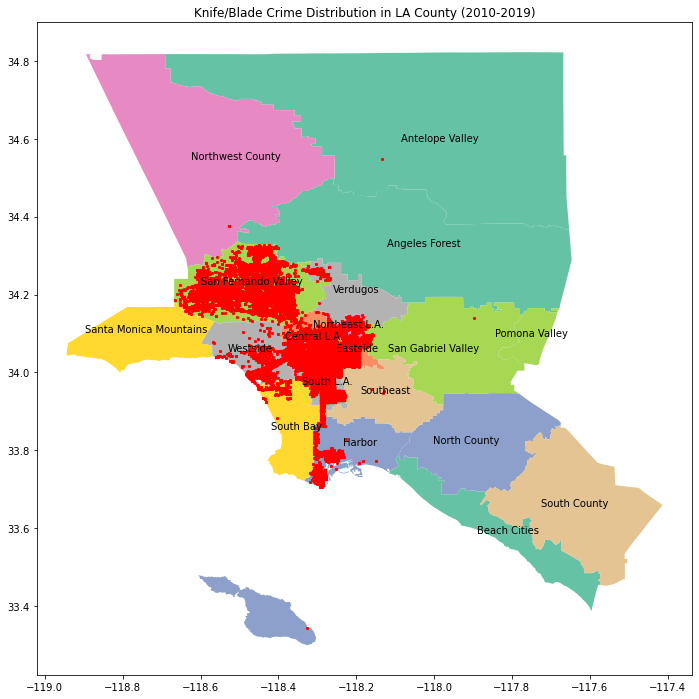

In [295]:
knife= gdf[gdf['Weapon']=='Knife/Blade']

knife.plot(ax=LACounty.plot(cmap= 'Set2', figsize=(20,12)), marker='x', color='red', markersize=5) 


for idx, row in LACounty.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.title('Knife/Blade Crime Distribution in LA County (2010-2019)')
plt.show()

<ipython-input-296-d9939c626fae>:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'], xy=row['coords'],


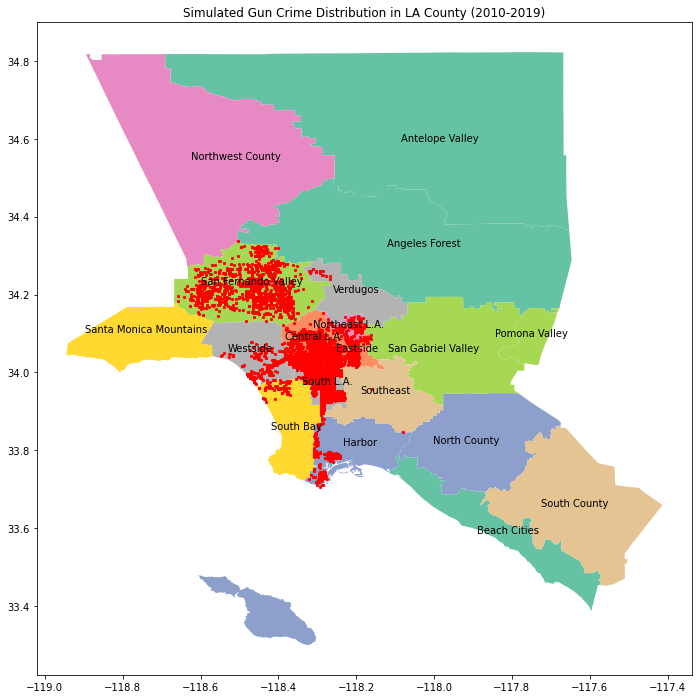

In [296]:
simGun= gdf[gdf['Weapon']=='Simulated Gun']

simGun.plot(ax=LACounty.plot(cmap= 'Set2', figsize=(20,12)), marker='x', color='red', markersize=5) 


for idx, row in LACounty.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.title('Simulated Gun Crime Distribution in LA County (2010-2019)')
plt.show()

In [297]:
crimeData.Incident_Date =pd.to_datetime(crimeData['Incident_Date']) 


In [298]:
crimeData= crimeData.sort_values(by=['Incident_Date'])

In [299]:
crimeData

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long,geometry
94256,2013-08-22T00:00:00,2010-01-01,"RAPE, ATTEMPTED",F,Physical/Body Force,33.9965,-118.2783,POINT (-118.27830 33.99650)
94607,2016-02-03T00:00:00,2010-01-01,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,M,Physical/Body Force,34.2084,-118.5011,POINT (-118.50110 34.20840)
94609,2016-08-26T00:00:00,2010-01-01,ORAL COPULATION,M,Physical/Body Force,34.2212,-118.5027,POINT (-118.50270 34.22120)
94626,2016-01-26T00:00:00,2010-01-01,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,F,Physical/Body Force,34.0029,-118.2718,POINT (-118.27180 34.00290)
94627,2016-03-16T00:00:00,2010-01-01,SEXUAL PENETRATION W/FOREIGN OBJECT,F,Physical/Body Force,33.9960,-118.2543,POINT (-118.25430 33.99600)
...,...,...,...,...,...,...,...,...
1951571,6222019-01-01T00:00:00,2019-06-22,ATTEMPTED ROBBERY,F,Physical/Body Force,33.9915,-118.3089,POINT (-118.30890 33.99150)
1951573,6222019-01-01T00:00:00,2019-06-22,BRANDISH WEAPON,M,Simulated Gun,33.9737,-118.2739,POINT (-118.27390 33.97370)
1951575,6222019-01-01T00:00:00,2019-06-22,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,Firearm,33.9854,-118.3352,POINT (-118.33520 33.98540)
1962033,6222019-01-01T00:00:00,2019-06-22,BATTERY - SIMPLE ASSAULT,M,Physical/Body Force,33.9933,-118.4765,POINT (-118.47650 33.99330)


In [300]:
for i in range(len(crimeData['Crime'])):
    if re.search(r"(SEX)|(RAPE)|(COPULATION)|(LEWD)|(INDECENT)", crimeData['Crime'].iloc[i]):
        crimeData['Crime'].iloc[i] = 'Sex Crime'

<ipython-input-300-5a11564772ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimeData['Crime'].iloc[i] = 'Sex Crime'


Text(0.5, 1.0, 'Top 20 Crimes Committed (2010-2019)')

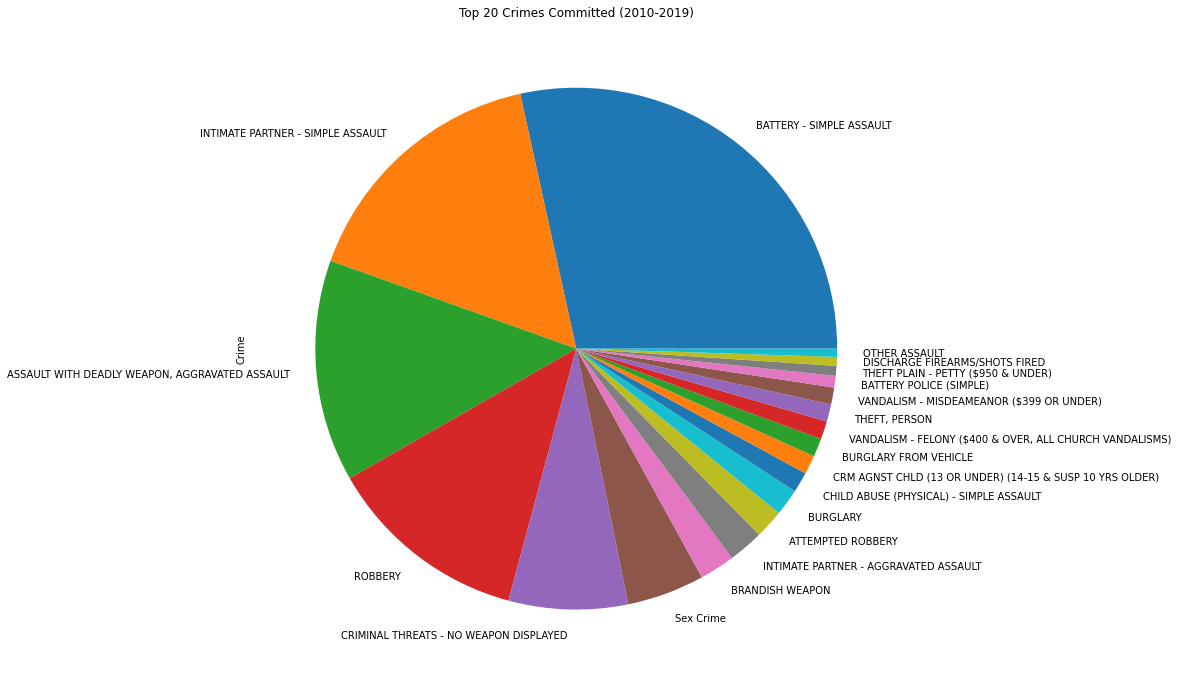

In [301]:
crimeData.Crime.value_counts().head(20).plot.pie(figsize= (20,12))
plt.title('Top 20 Crimes Committed (2010-2019)')

In [302]:
sexVic = crimeData[crimeData['Crime']=='Sex Crime']

Text(0.5, 1.0, 'Victims of Sex Crimes by Sex(2010-2019)')

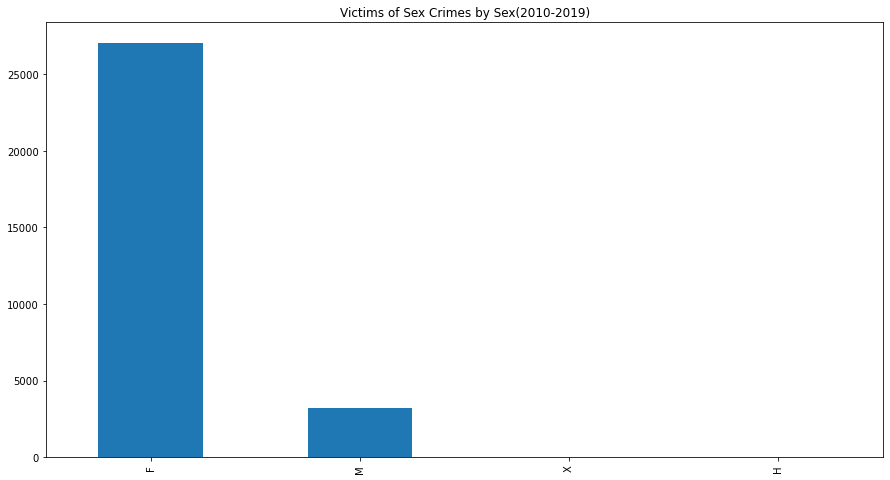

In [303]:
sexVic['Victim Sex'].value_counts().plot.bar(figsize=(15,8))
plt.title('Victims of Sex Crimes by Sex(2010-2019)')

In [304]:
gdf = geopandas.GeoDataFrame(
    crimeData, geometry=geopandas.points_from_xy(crimeData.Long, crimeData.Lat))

<ipython-input-305-2fd34fed83dd>:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['name'], xy=row['coords'],


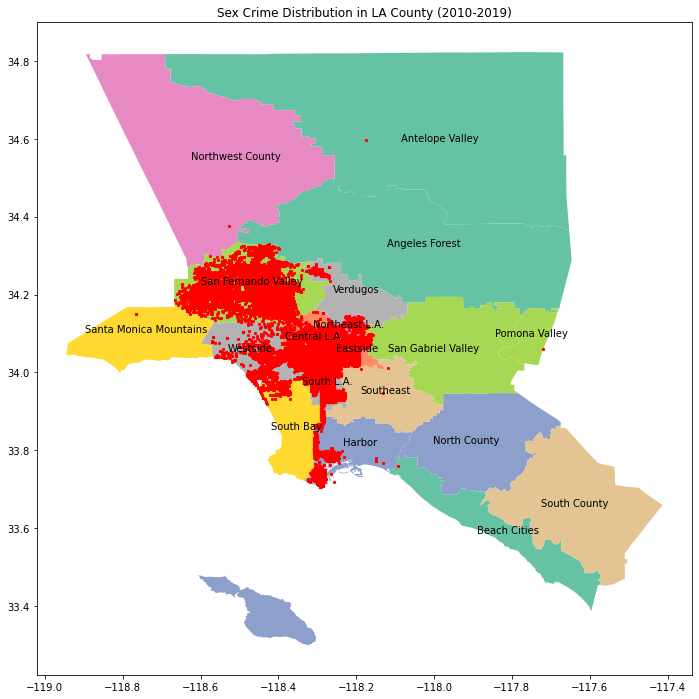

In [305]:
sexCrime= gdf[gdf['Crime']=='Sex Crime']

sexCrime.plot(ax=LACounty.plot(cmap= 'Set2', figsize=(20,12)), marker='x', color='red', markersize=5) 


for idx, row in LACounty.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'],
                 horizontalalignment='center')

plt.title('Sex Crime Distribution in LA County (2010-2019)')
plt.show()

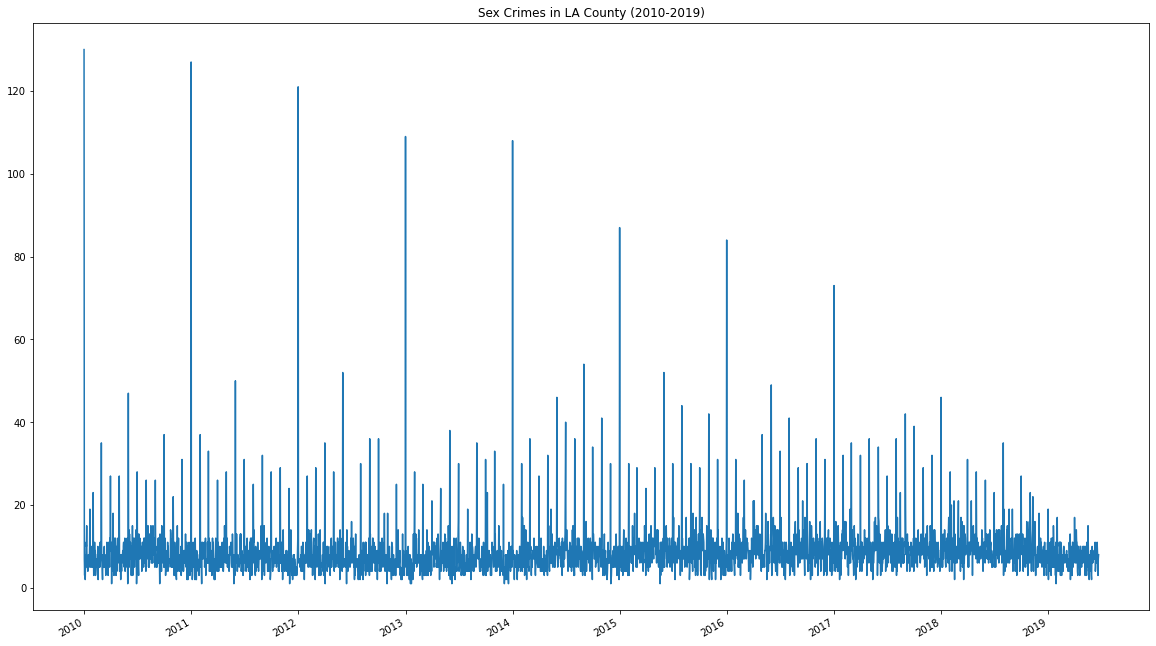

In [306]:

sexCrime['Incident_Date'].value_counts().sort_index().plot.line(figsize=(20,12))
plt.title('Sex Crimes in LA County (2010-2019)')
plt.show()

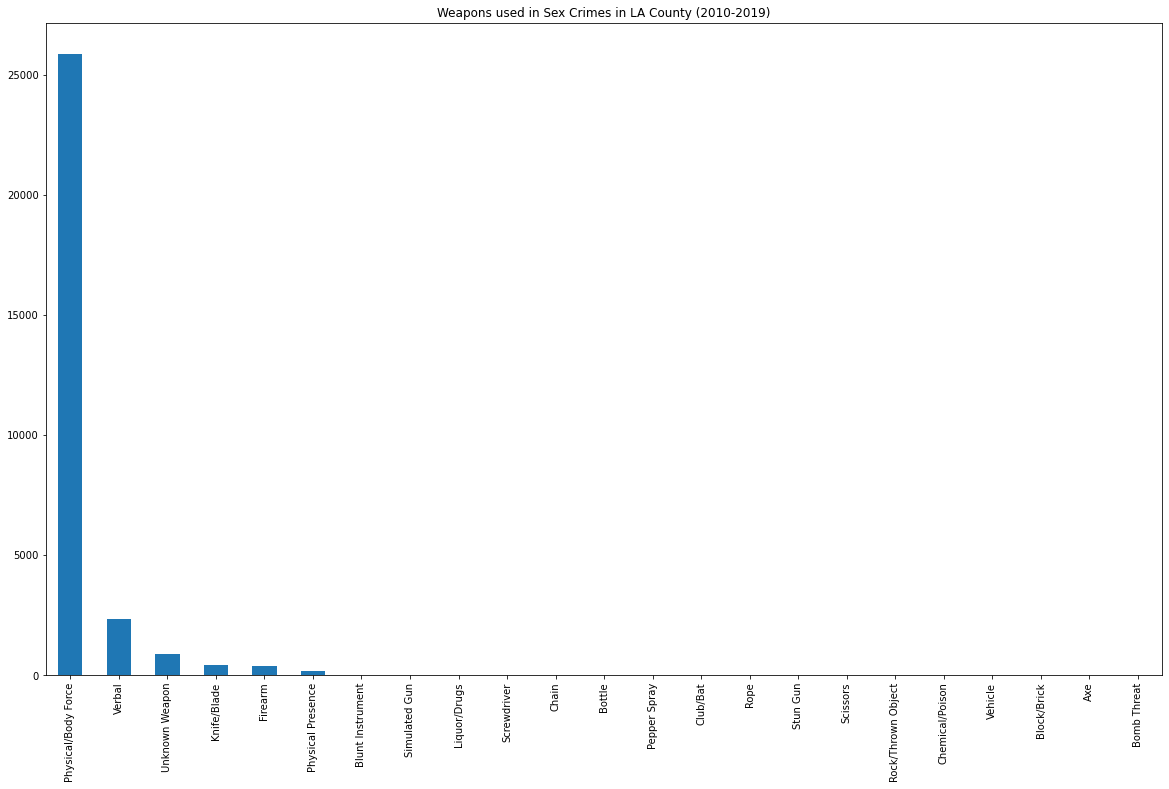

In [307]:
sexCrime.Weapon.value_counts().plot.bar(figsize=(20,12))
plt.title('Weapons used in Sex Crimes in LA County (2010-2019)')
plt.show()

In [308]:
for i in range(len(crimeData['Report_Date'])):
    if re.search("(\d{3})20", crimeData['Report_Date'].iloc[i]):
        date =[j for j in str(crimeData['Report_Date'].iloc[i])]
        s= ''
        crimeData['Report_Date'].iloc[i] = f"{s.join(date[3:7])}-0{date[0]}-{s.join(date[1:3])}"

<ipython-input-308-81b759587552>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimeData['Report_Date'].iloc[i] = f"{s.join(date[3:7])}-0{date[0]}-{s.join(date[1:3])}"


In [309]:
crimeData.tail(10)

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long,geometry
1962039,2019-06-22,2019-06-22,THROWING OBJECT AT MOVING VEHICLE,M,Rock/Thrown Object,33.9431,-118.3743,POINT (-118.37430 33.94310)
1962041,2019-06-22,2019-06-22,EXTORTION,M,Verbal,33.9873,-118.4403,POINT (-118.44030 33.98730)
1962050,2019-06-23,2019-06-22,Sex Crime,F,Physical/Body Force,33.9883,-118.4708,POINT (-118.47080 33.98830)
1951556,2019-06-22,2019-06-22,VANDALISM - MISDEAMEANOR ($399 OR UNDER),F,Physical/Body Force,33.9979,-118.2871,POINT (-118.28710 33.99790)
1951570,2019-06-22,2019-06-22,INTIMATE PARTNER - SIMPLE ASSAULT,F,Physical/Body Force,34.0017,-118.2979,POINT (-118.29790 34.00170)
1951571,2019-06-22,2019-06-22,ATTEMPTED ROBBERY,F,Physical/Body Force,33.9915,-118.3089,POINT (-118.30890 33.99150)
1951573,2019-06-22,2019-06-22,BRANDISH WEAPON,M,Simulated Gun,33.9737,-118.2739,POINT (-118.27390 33.97370)
1951575,2019-06-22,2019-06-22,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,Firearm,33.9854,-118.3352,POINT (-118.33520 33.98540)
1962033,2019-06-22,2019-06-22,BATTERY - SIMPLE ASSAULT,M,Physical/Body Force,33.9933,-118.4765,POINT (-118.47650 33.99330)
1900143,2019-06-22,2019-06-22,INTIMATE PARTNER - SIMPLE ASSAULT,F,Physical/Body Force,34.0452,-118.2842,POINT (-118.28420 34.04520)


In [312]:
crimeData.Report_Date = pd.to_datetime(crimeData.Report_Date)

In [313]:
crimeData['Time_Dif']= crimeData.Report_Date-crimeData.Incident_Date

In [314]:
sexCrime

,Report_Date,Incident_Date,Crime,Victim Sex,Weapon,Lat,Long,geometry,Time_Dif
94256,2013-08-22,2010-01-01,Sex Crime,F,Physical/Body Force,33.9965,-118.2783,POINT (-118.27830 33.99650),1329 days
94607,2016-02-03,2010-01-01,Sex Crime,M,Physical/Body Force,34.2084,-118.5011,POINT (-118.50110 34.20840),2224 days
94609,2016-08-26,2010-01-01,Sex Crime,M,Physical/Body Force,34.2212,-118.5027,POINT (-118.50270 34.22120),2429 days
94626,2016-01-26,2010-01-01,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,F,Physical/Body Force,34.0029,-118.2718,POINT (-118.27180 34.00290),2216 days
94627,2016-03-16,2010-01-01,Sex Crime,F,Physical/Body Force,33.9960,-118.2543,POINT (-118.25430 33.99600),2266 days
...,...,...,...,...,...,...,...,...,...
1951571,2019-06-22,2019-06-22,ATTEMPTED ROBBERY,F,Physical/Body Force,33.9915,-118.3089,POINT (-118.30890 33.99150),0 days
1951573,2019-06-22,2019-06-22,BRANDISH WEAPON,M,Simulated Gun,33.9737,-118.2739,POINT (-118.27390 33.97370),0 days
1951575,2019-06-22,2019-06-22,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",M,Firearm,33.9854,-118.3352,POINT (-118.33520 33.98540),0 days
1962033,2019-06-22,2019-06-22,BATTERY - SIMPLE ASSAULT,M,Physical/Body Force,33.9933,-118.4765,POINT (-118.47650 33.99330),0 days


In [315]:
sexVic = crimeData[crimeData['Crime']=='Sex Crime']

In [318]:
sexVic['Time_Dif'].mean()

Timedelta('111 days 23:30:49.381899914')

In [319]:
sexVic['Time_Dif'].max()

Timedelta('3442 days 00:00:00')